# Programming Assignment 2 - solutions

authors: Daniel Tabas (TA) and Chase Dowling

contact: dtabas@uw.edu

course: EE PMP 555, Spring '22

In [2]:
#here we'll construct the neccessary matrices for the above example network

import numpy as np
import matplotlib.pyplot as plt

#node edge incidence matrix scaled by admittance
#these are just arbitrary admittance values for this assignment
F = np.array([[3,0,-3,0],
              [0,5,-5,0],
              [0,5,0,-5],
              [0,0,4,-4]])

self_admittance = np.sum(np.abs(F), axis=0)

off_diag = np.array([[0,0,-3,0],
                     [0,0,-5,-5],
                     [-3,-5,0,-4],
                     [0,-5,-4,0]])

#admittance matrix
B = np.diag(self_admittance) + off_diag

#stacked
H = np.vstack((F, B))

In [3]:
#true flows and power injections for reference

f = 0.01*np.array([5,-2,-1,2])
p = 0.01*np.array([5,-3,-1,-1])

z = np.expand_dims(np.append(f, p), axis=1)

## Homework questions

### Problem 1: L1 regression

Let's look at how the LASSO regression problem works. There is no closed form solution so we often use a form of gradient descent called coordinate descent. For now we won't worry about how coordinate descent works, but just go ahead and see how the LASSO solution looks for various values of $\lambda$. First read through the following example code.

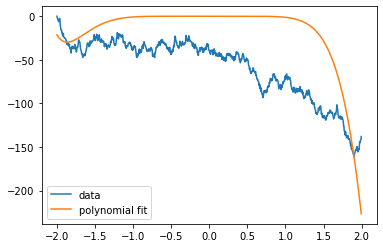

coefficients: 
[-0.         -0.         -0.         -0.         -0.         -0.
 -0.02764215 -0.         -1.18675482 -0.20374273  0.17584097]


In [4]:
#We're going to try and fit a polynomial function to a noisy time series and
#see how various values of lambda influences the fit

def poly_basis(x, k):
    #this function will help us quickly generate a polynomial basis
    #k is the largest polynomial degree the basis runs to
    out = []
    for i in range(k+1):
        #notice that first value of i will be 0, so the bias term is included
        out.append(np.power(x, i))
    return(out)

X_ran = np.arange(-2,2,0.004)  #the range of values we'll consider

X_poly_basis = np.asarray(poly_basis(X_ran, 10)).T    #the range of values passed through a polynomial basis

#generate a noisy time series
Y = [0.0]
for i in range(999):
    Y.append(Y[-1]+np.random.normal(0,2))
    
#we need to solve for the weights w such that
#X_poly_basis.dot(w) = Y, we'll use the LASSO objective that combines L2 and L1 loss

#import the LASSO solver
from sklearn import linear_model

#we'll use the built in Lasso solver in Scikit-learn
#the input value alpha is the regularization constant lambda as we've written above
#don't mess with the input options other than alpha, for example, fit_intercept is default to be true
#and assumes you didn't include the bias term in your basis function
lasso_regressor = linear_model.Lasso(alpha=100, fit_intercept=False, tol=0.01, max_iter=10000)

#this fits the outputs Y to the polynomial basis of inputs in the range -2 to 2
lasso_regressor.fit(X_poly_basis, Y)

#these are the weights the model learns
w = lasso_regressor.coef_

#we've used a large regularization constant, alpha=100, notice the model doesn't fit
#very well

plt.plot(X_ran,Y, label="data")
plt.plot(X_ran,X_poly_basis.dot(w), label="polynomial fit")
plt.legend()
plt.show()

print("coefficients: ")
print(w)

Now, fit with the LASSO regressor for several values of alpha between 0.001 and 100.0. Plot at least five different polynomial fits like the above for different values of alpha. For each alpha, print the coefficients that it solves for along with the plot and describe what's happening.

coefficients: 
[-4.38593507e+01 -2.15021537e+01 -1.11400107e+01 -6.18955923e-01
 -2.39795203e-01 -2.33023068e-01 -1.38345963e-03 -6.10128567e-02
  8.48739915e-03 -1.48219107e-02  3.54155354e-03]
coefficients: 
[-4.38477100e+01 -2.14817984e+01 -1.11372824e+01 -6.24353361e-01
 -2.41645529e-01 -2.33481046e-01 -1.47886542e-03 -6.09878553e-02
  8.48127335e-03 -1.48062983e-02  3.55186865e-03]
coefficients: 
[-4.37313035e+01 -2.12782446e+01 -1.11099995e+01 -6.78327740e-01
 -2.60148789e-01 -2.38060830e-01 -2.43292331e-03 -6.07378414e-02
  8.42001526e-03 -1.46501746e-02  3.65501972e-03]
coefficients: 
[-4.20461416e+01 -2.15631521e+01 -9.26512635e+00 -1.92400740e-01
 -6.21341859e-01 -0.00000000e+00 -5.60758823e-01 -2.22012669e-02
 -2.68946911e-03 -5.31757447e-02  4.28503182e-02]
coefficients: 
[-33.69925221  -0.          -0.          -0.          -0.
  -4.42648649  -3.38942259  -0.          -0.           0.14065627
   0.17280081]


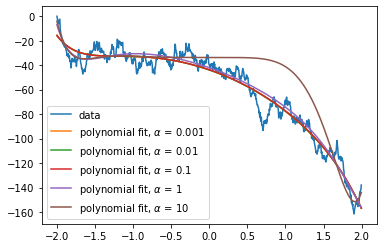

In [5]:
# insert your code here

plt.figure()
plt.plot(X_ran,Y, label="data")

for alpha in [.001,.01,.1,1,10]:
    
    lasso_regressor = linear_model.Lasso(alpha=alpha, fit_intercept=False, tol=0.01, max_iter=1000000)

    #this fits the outputs Y to the polynomial basis of inputs in the range -2 to 2
    lasso_regressor.fit(X_poly_basis, Y)

    #these are the weights the model learns
    w = lasso_regressor.coef_
    
    plt.plot(X_ran,X_poly_basis.dot(w), label=fr'polynomial fit, $\alpha$ = {alpha}')
    plt.legend()

    print("coefficients: ")
    print(w)
    
plt.show()

What is happening? As $\alpha$ increases, the number of coefficients that are exactly zero increases. We see a decrease in model complexity paralleled by a decrease in fidelity.

### Problem 2: Norm balls

The L1-and L2-norms are special cases of the Lp-norm, which is a family of functions that define a metric space where the data "lives". One way to think of machine learning tasks is transforming that metric space until the data resembles something manageable with simple models, almost like untangling a knot. The Lp-norm for an $n$ dimensional vector $x$ is defined as,

<center>$||x||_{p} = (\sum_{i=1}^{n}|x_{i}|^{p})^\frac{1}{p} $</center>

If we take the limit $p \rightarrow \infty$, then the L-$\infty$ norm gives us a special function. For multiple values of p, plot the unit ball in 2 dimensions, and make a guess as to what the L-$\infty$ norm looks like. The unit ball is the value of the norm for vectors a distance of 1 away from the origin according to the norm. Below are examples for the 1 and 2 norms. If p is too large, you won't be able to plot it with the functions I've given, so look at values of p like 3, 4, and 5 and then make a guess.

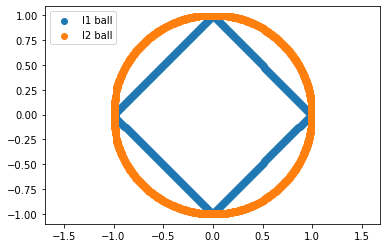

In [6]:
def l1_norm(x):
    out = 0
    for x_i in x:
        out += np.abs(x_i)
    return(out)

def l2_norm(x):
    out = 0
    for x_i in x:
        out += np.power(x_i, 2)
    return(np.sqrt(out))

x_1 = np.arange(-1,1,0.01)
x_2 = np.arange(-1,1,0.01)
tol = 0.01

l1_unit_ball_values = []
l2_unit_ball_values = []

for x_i in x_1:
    for x_j in x_2:
        l1 = l1_norm([x_i, x_j])
        l2 = l2_norm([x_i, x_j])
        if l1 > 1 - tol and  l1 < 1 + tol:   #check to see if the value of the L1 norm is close to 1
            l1_unit_ball_values.append([x_i, x_j])
        if l2 > 1 - tol and l2 < 1 + tol:    #check to see if the value of the L2 norm is close to 1 
            l2_unit_ball_values.append([x_i, x_j])
        
l1_ball = np.asarray(l1_unit_ball_values) #transform the list of vectors/pairs into a numpy array
l2_ball = np.asarray(l2_unit_ball_values)

plt.scatter(l1_ball[:,0], l1_ball[:,1], label="l1 ball")
plt.scatter(l2_ball[:,0], l2_ball[:,1], label="l2 ball")
plt.legend(loc=2)
plt.axis('equal') #this makes the axes the same scale so that the circle isn't elliptical looking
plt.show()

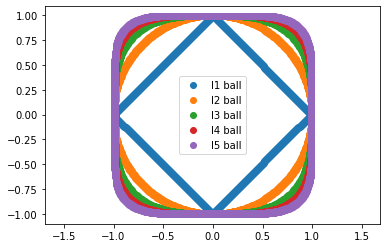

In [7]:
#add your code here, consider writing a more general
#function than l1_norm() or l2_norm() above for the lp_norm

def lp_norm(x,p):
    return np.sum(np.abs(x)**p)**(1/p)

def plot_ball(p):
    x_1 = np.arange(-1,1,0.01)
    x_2 = np.arange(-1,1,0.01)
    tol = 0.01

    unit_ball_values = []
    
    for x_i in x_1:
        for x_j in x_2:
            lp = lp_norm(np.array([x_i, x_j]),p)
            if lp > 1 - tol and  lp < 1 + tol:   #check to see if the value of the L1 norm is close to 1
                unit_ball_values.append([x_i, x_j])
            
    lp_ball = np.asarray(unit_ball_values)
    
    plt.scatter(lp_ball[:,0], lp_ball[:,1],label=f"l{p} ball")
        
for p in [1,2,3,4,5]:
    plot_ball(p)

plt.legend()
plt.axis('equal') #this makes the axes the same scale so that the circle isn't elliptical looking
plt.show()

As $p \rightarrow \infty$, we can see that the norm ball approaches a hypercube given by the Cartesian product of intervals $[-1,1]$. The $\infty$-norm unit ball is the set of vectors whose largest component is exactly 1 in magnitude.

### Problem 3: Linear state estimation in power systems

For this problem you'll need to read the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) carefully. You are given $k$ noisy samples of $z$: the line flows and power injections. Instantiate a linear model and find the solution $x$ of nodal phase angles. Print the loss (1 value across all samples). Hint: you're going to find an $x$ for each sample of $z$, we need to find the best $x$ the minimizes the loss for any $z$.

In [8]:
#here are the samples, they are not formatted correctly, you'll need to format them correctly 
#in order to use linear_model.LinearRegression().fit()
samples_1 = []

for i in range(100):
    samples_1.append(z + np.random.normal(0,0.02,size=z.shape)) #the true value + some noise

In [9]:
#insert your code here

samples_1 = np.asarray(samples_1)[:,:,0]
print(samples_1.shape)

model = linear_model.LinearRegression().fit(H, samples_1.T) #find the best x for each sample
x_s = model.coef_ #get the x's
print("size of solving for all x's at once:", x_s.shape, "\n")  #100 x's of size 8
x_hat = np.mean(x_s, axis=0)   #since the noise is Gaussian, the mean of all the best x's will minimize the loss for any z sample in sample_1 list
print("best x:", x_hat, "\n")
loss = np.linalg.norm(H.dot(x_hat) - z, 2)
print("Error:", loss, "\n")

(100, 8)
size of solving for all x's at once: (100, 4) 

best x: [ 0.01414757 -0.00663985 -0.00178356 -0.00572415] 

Error: 0.2339889012039404 



Note that the usual least squares solution given by $(H^TH)^{-1}H^T\bar{z}$ where $\bar{z}$ is the average across samples doesn't work because $H$ is not full rank. To see this, just check that the columns sum to the zero vector. This is a result of the way $B$ and $F$ are defined. Since $H$ is not full rank, $H^TH$ is not invertible. There are several ways to remedy this. One way is to use the SVD to compute the pseudoinverse of $H$. Another way is to eliminate one of the columns of $H$ by measuring voltage angles relative to a slack bus. Ask the TA if you would like a longer explanation.

### Problem 4: Weighted estimation

Our example power grid has very good power injection sensors with very little noise variance, and our cheaper line flow sensors have very high noise variance. In the example below, we show how to performed _weighted_ least squares, in order to bias the solution to rely on the high quality data more than the low quality data.

In [10]:
weights = np.ones(z.shape)[:,0]  #the weights object must be 1-dimensional
model = linear_model.LinearRegression().fit(H, z, sample_weight=weights)  
x_hat = model.coef_.T

#here I've just passed in weights equal to 1, so the solution is unchanged

In [11]:
# Here, we generate some noisy samples where the injection sensors are accurate and the line flow sensors are noisy.

samples_2 = []

for i in range(100):
    injection_noise = np.random.normal(0,0.01,size=z[0:4].shape)  #variance equal to 0.01
    line_noise = np.random.normal(0,0.03,size=z[0:4].shape)       #variance equal to 0.03
    samples_2.append(z + np.expand_dims(np.append(line_noise,injection_noise),axis=1)) #the true value + some noise
    
samples_2 = np.asarray(samples_2)[:,:,0].T

Now, find a vector of sample weights that improves on the loss over the vector of weights all equal to 1.

In [12]:
#insert your code here

f = 0.01*np.array([5,-2,-1,2])
p = 0.01*np.array([5,-3,-1,-1])

z = np.expand_dims(np.append(f, p), axis=1)

weights_one = np.ones(z.shape)[:,0]  #the weights object must be 1-dimensional
model = linear_model.LinearRegression().fit(H, samples_2, sample_weight=weights_one)  
x_hat_one = np.mean(model.coef_, axis=0)

weights_f = 0.9*np.ones(f.shape)
weights_p = 1.1*np.ones(p.shape)
weights = np.concatenate((weights_f, weights_p))
model = linear_model.LinearRegression().fit(H, samples_2, sample_weight=weights)  #this sets *all* samples to this weight scheme
x_hat_bias = np.mean(model.coef_, axis=0)

loss = np.linalg.norm(H.dot(x_hat_one) - z, 2)
print("Error:", loss, "\n")

loss = np.linalg.norm(H.dot(x_hat_bias) - z, 2)
print("Error:", loss, "\n")

Error: 0.23449755051499468 

Error: 0.2344695736791063 



### Problem 5: Eliminating outliers

We are again given a sequence of observations of power flows and injection, but there are several bad measurements. The noise is Gaussian; use what we know about the Gaussian distribution to derive a threshold-type means of eliminating outlier data. Compare the loss of the model with and without the outliers.

In [13]:
#100 x 8 array of z samples
samples_3_array = np.loadtxt("homework_2_data.txt")

In [14]:
#insert your code here

sample_3_mean = np.mean(samples_3_array, axis=0)  #compute the sample mean
sample_3_var = np.var(samples_3_array, axis=0)    #compute the sample variance

#apply a Chi-squared test statistic to each feature column of z
test_stats = []
for row in range(samples_3_array.shape[0]):
    test_stat = np.sum(np.power(np.power(sample_3_var, -1)*(samples_3_array[row,:] - sample_3_mean),2))
    test_stats.append(test_stat)
    
outliers = []

for i in range(len(test_stats)):
    if test_stats[i] > 10:  #inspect the test stat values and find that there are small values and 4 very large ones, this threshold is arbitrary
        outliers.append(i)
        print("outlier at index: ", i)
        
outliers = np.array(outliers) #conver to array object to use np delete function

samples_3_clean = np.delete(samples_3_array, outliers, axis=0)
print("\n")
print("size with outliers: ", samples_3_clean.shape)
print("size without outliers: ", samples_3_array.shape)

model = linear_model.LinearRegression().fit(H, samples_3_array.T)
x_hat_outliers = np.mean(model.coef_, axis=0)
loss_outliers = np.linalg.norm(H.dot(x_hat_outliers) - z, 2)

model = linear_model.LinearRegression().fit(H, samples_3_clean.T)
x_hat_clean = np.mean(model.coef_, axis=0)
loss_clean = np.linalg.norm(H.dot(x_hat_clean) - z, 2)

print("loss with outliers: ", loss_outliers)
print("loss without outliers: ", loss_clean)

outlier at index:  5
outlier at index:  13
outlier at index:  71
outlier at index:  89


size with outliers:  (96, 8)
size without outliers:  (100, 8)
loss with outliers:  1.324785493545909
loss without outliers:  0.24142724950571204
